In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import json
from datasets import load_dataset


dataset = load_dataset("gsm8k", "main")
train_questions = np.array(dataset["train"]["question"])
train_answers = np.array(dataset["train"]['answer'])

test_questions = np.array(dataset["test"]["question"])
test_answers = np.array(dataset["test"]['answer'])

In [76]:
a = np.load("ckpts/gsm8k_orig_3epochs_shuffle1_lr0.0002_bs128/checkpoint-174/train_answer_types50_seed0_temp0.8.npy")==0

In [82]:
b = np.load("ckpts/gsm8k_orig_3epochs_shuffle2_lr0.0002_bs128/checkpoint-174/train_answer_types50_seed1_temp0.8.npy")==0

In [83]:
a.shape

(7473, 50)

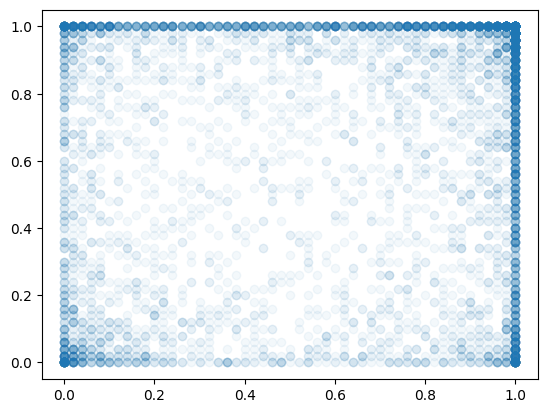

In [84]:
plt.scatter(a.mean(axis=-1), b.mean(axis=-1), alpha=0.05)

In [2]:
def get_stats(train_name):
    num_memorized_all = []
    num_correct_different_all = []
    num_incorrect_all = []
    perplexities_all = []


    if "Qwen" in train_name and "3epochs" in train_name:
        ckpts = ["62", "124", "186"] 
    elif "Qwen" in train_name and "6epochs" in train_name:
        ckpts = ["62", "124", "186", "249", "311", "372"] 
    elif "6epochs_half" in train_name:
        ckpts = ["29", "58", "87", "116", "145", "174"]
    elif "3epochs_half" in train_name:
        ckpts = ["29", "58", "87"]
    elif "12epochs_quarter" in train_name:
        ckpts = ["29", "58", "87", "116", "145"]
    elif "24epochs_eighth" in train_name:
        ckpts = ["29", "58", "87", "116", "145"]
    elif "_6epochs" in train_name:
        ckpts = ["58", "116", "175", "233", "292", "348"]
    elif "_12epochs" in train_name:
        ckpts = ["116", "232", "348", "464", "580", "696"]
    elif "_1epochs" in train_name:
        ckpts = ["58"]
    elif "_3epochs" in train_name:
        ckpts = ["58", "116", "174"]

    for ckpt in ckpts:
        try:
            train_correct = (np.load("ckpts/"+train_name+"/checkpoint-"+ckpt+ "/train_answer_types5_seed2.npy")==0)
            train_samples = (np.load("ckpts/"+train_name+"/checkpoint-"+ckpt+ "/train_answers5_seed2.npy"))
        except:
            train_correct = (np.load("ckpts/"+train_name+"/checkpoint-"+ckpt+ "/train_answer_types5_seed2_temp0.8.npy")==0)
            train_samples = (np.load("ckpts/"+train_name+"/checkpoint-"+ckpt+ "/train_answers5_seed2_temp0.8.npy"))
            
        # if "fill" not in train_name:
        #     subsample_idxs = np.load("ckpts/"+train_name+"/subsample_idxs.npy")
        #     train_correct = train_correct[subsample_idxs]
        #     train_samples = train_samples[subsample_idxs]
        # else:
        subsample_idxs = np.arange(len(train_answers))

        num_memorized_ckpt = []
        num_correct_different_ckpt = []
        num_incorrect_ckpt = []

        for input_idx in range(len(subsample_idxs)):
            num_memorized = 0
            num_correct_different = 0
            num_incorrect = 0
            for sample_idx in range(5):
                correct = train_correct[input_idx, sample_idx]
                if correct:
                    if train_samples[input_idx][sample_idx].strip() == train_answers[subsample_idxs[input_idx]].strip():
                        num_memorized+=1
                    else:
                        num_correct_different+=1
                else:
                    num_incorrect+=1 
            num_memorized_ckpt.append(num_memorized)
            num_correct_different_ckpt.append(num_correct_different)
            num_incorrect_ckpt.append(num_incorrect)
        
        num_memorized_all.append(num_memorized_ckpt)
        num_correct_different_all.append(num_correct_different_ckpt)
        num_incorrect_all.append(num_incorrect_ckpt)
        
        
        perplexities = np.load("ckpts/"+train_name+"/checkpoint-"+ckpt+ "/train_perplexities.npy")[subsample_idxs]
        perplexities_all.append(perplexities)
        
    num_memorized_all = np.array(num_memorized_all)
    num_correct_different_all = np.array(num_correct_different_all)
    num_incorrect_all = np.array(num_incorrect_all)
    perplexities_all = np.array(perplexities_all)
    
    test_accs_all = []
    test_samples_all = []

    for ckpt in ckpts:
        try:
            test_accs = (np.load("ckpts/"+train_name+"/checkpoint-"+ckpt+ "/test_answer_types50_seed2.npy")==0)
            test_samples = (np.load("ckpts/"+train_name+"/checkpoint-"+ckpt+ "/test_answers50_seed2.npy"))
        except:
            try:
                test_accs = (np.load("ckpts/"+train_name+"/checkpoint-"+ckpt+ "/test_answer_types50_seed2_temp0.8.npy")==0)
                test_samples = (np.load("ckpts/"+train_name+"/checkpoint-"+ckpt+ "/test_answers50_seed2_temp0.8.npy"))
            except:
                test_accs = (np.load("ckpts/"+train_name+"/checkpoint-"+ckpt+ "/test_answer_types5_seed2_temp0.8.npy")==0)
                test_samples = (np.load("ckpts/"+train_name+"/checkpoint-"+ckpt+ "/test_answers5_seed2_temp0.8.npy"))
        test_accs_all.append(test_accs)
        test_samples_all.append(test_samples)

    test_accs_all = np.array(test_accs_all)
    test_samples_all = np.array(test_samples_all)
    
    return_dict = {}
    return_dict["num_memorized_all"] = num_memorized_all
    return_dict["num_correct_different_all"] = num_correct_different_all
    return_dict["num_incorrect_all"] = num_incorrect_all
    return_dict["perplexities_all"] = perplexities_all
    return_dict["test_accs_all"] = test_accs_all
    return_dict["test_samples_all"] = test_samples_all
    
    return return_dict



In [3]:


def get_ratios2(stats_dict, perp_threshold=-2.5):
    num_incorrect_all = stats_dict["num_incorrect_all"]
    num_memorized_all = stats_dict["num_memorized_all"]
    num_correct_different_all = stats_dict["num_correct_different_all"]
    perplexities_all = stats_dict["perplexities_all"]
    test_accs_all = stats_dict["test_accs_all"]
    test_samples_all = stats_dict["test_samples_all"]
    # train_samples_all = stats_dict["train_samples_all"]
    
    
    
    
    
    memorization_mask = np.ones(num_incorrect_all.shape)*-1
    accs_all = np.ones(num_incorrect_all.shape)*-1
    
    
    # train accuracies
    # train mmemorization
    
    # max over memorization mask through training
    # min over prev accuracies, curr accuracy
    
    
    for i in range(len(num_memorized_all)):

        
        # accs = (num_memorized_all[i]+num_correct_different_all[i])/5
        # unmemorized_acc[i] = accs
        
        # print(get_n_maj_acc(train_samples_all[i], 5, num_samples=1, eval_type="train"))
        # 1/0
        
        accs_all[i] = (num_memorized_all[i]+num_correct_different_all[i])/5
        # (num_memorized_all[i]+num_correct_different_all[i] >= acc_threhshold)
        # get_n_maj_acc(train_samples_all[i], 5, num_samples=1, eval_type="train")
        
        
        memorization_mask[i] = (np.log(np.log((perplexities_all[i]))) >= perp_threshold)
        # memorization_mask[i] = num_memorized_all[i] == 0

        # memorized_idxs = np.where((np.log(np.log((perplexities_all[i]))) < perp_threshold))[0]
        # unmemorized_acc[i][memorized_idxs] = 0
        # print(unmemorized_acc[i])
        
    
    
    
    
    unmemorized_acc_cummax = np.array([(accs_all*memorization_mask)[:j+1].max(axis=0) for j in range(len(num_memorized_all))])
    
    print(unmemorized_acc_cummax.shape)
    print(accs_all.shape)
    unmemorized_acc_cummax = (np.min([unmemorized_acc_cummax, accs_all], axis=0))
    unmemorized_acc_cummax_mean = unmemorized_acc_cummax.mean(axis=1)
    

    avg_test_acc = test_accs_all.mean(axis=1).mean(axis=1)
    
    # test_maj_50 = [np.mean(get_n_maj_acc(test_samples_all[i], 5, num_samples=1)) for i in range(len(test_samples_all))]
    
    
    return_dict = {}
    
    
    return_dict["unmemorized_acc_cummax"] = unmemorized_acc_cummax_mean
    return_dict["unmemorized_acc_cummax_all"] = unmemorized_acc_cummax

    return_dict["avg_test_acc"] = avg_test_acc
    # return_dict["test_maj_50"] = test_maj_50
            
    return return_dict

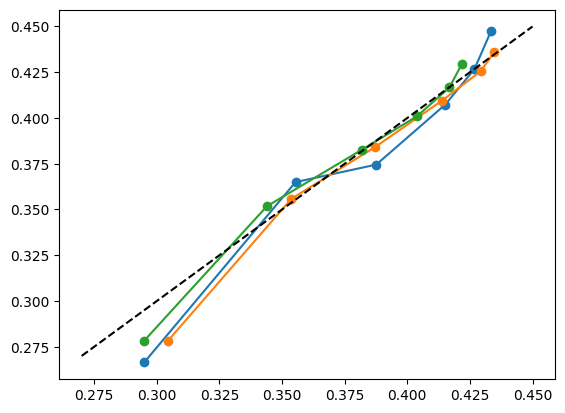

In [70]:
plt.plot(ratios_dict1["unmemorized_acc_cummax"], ratios_dict1["avg_test_acc"], "o-")
plt.plot(ratios_dict2["unmemorized_acc_cummax"], ratios_dict2["avg_test_acc"], "o-")
plt.plot(ratios_dict3["unmemorized_acc_cummax"], ratios_dict3["avg_test_acc"], "o-")

plt.plot([0.27, 0.45], [0.27, 0.45], "k--")

In [85]:
stats_dict1 = get_stats("gsm8k_orig_2epochs_shuffle1_lr0.0002_bs128")


UnboundLocalError: local variable 'ckpts' referenced before assignment

In [5]:
stats_dict2 = get_stats("gsm8k_orig_6epochs_shuffle2_lr5e-05_bs128")


In [98]:
stats_dict2["num_memorized_all"][:, 30]

array([0, 0, 0, 1, 1, 0])

In [99]:
stats_dict2["num_correct_different_all"][:, 30]

array([1, 4, 5, 4, 4, 5])

In [6]:
stats_dict3 = get_stats("gsm8k_orig_6epochs_full_lr5e-05_bs128")

In [7]:
stats_dict4 = get_stats("gsm8k_orig_6epochs_full_lr5e-07_bs128")

In [70]:
ratios_dict2

{'unmemorized_acc_cummax': array([0.30442928, 0.35375351, 0.38712699, 0.41391677, 0.42935903,
        0.43468487]),
 'unmemorized_acc_cummax_all': array([[0.4, 0.4, 0.2, ..., 0. , 0. , 0. ],
        [0.8, 0.4, 0. , ..., 0.2, 0.4, 0.4],
        [0.8, 0.4, 0.4, ..., 0.4, 0.4, 0.4],
        [0.8, 0.4, 0.4, ..., 0.4, 0.4, 0.4],
        [0.8, 0.4, 0.4, ..., 0.4, 0.4, 0.4],
        [0.8, 0.4, 0.4, ..., 0.4, 0.4, 0.4]]),
 'avg_test_acc': array([0.27824109, 0.35587566, 0.38407885, 0.40955269, 0.42562547,
        0.43593632])}

In [45]:
stats_dict6 = get_stats("gsm8k_orig_6epochs_full_lr2e-05_bs128_2")

FileNotFoundError: [Errno 2] No such file or directory: 'ckpts/gsm8k_orig_6epochs_full_lr2e-05_bs128_2/checkpoint-58/train_answer_types5_seed2_temp0.8.npy'

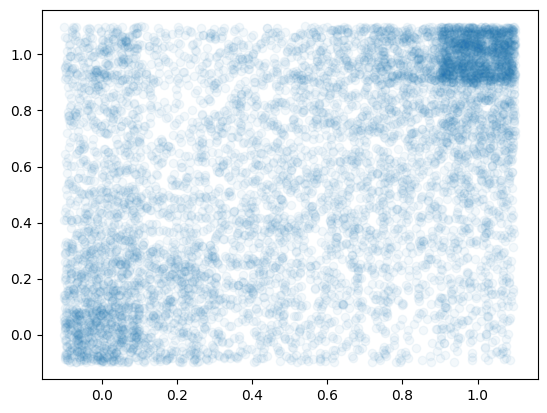

In [39]:
plt.scatter(ratios_dict5["unmemorized_acc_cummax_all"][-1]+np.random.uniform(-0.1, 0.1, len(shuffle_idxs1)), np.max([ratios_dict1["unmemorized_acc_cummax_all"][-1], ratios_dict2["unmemorized_acc_cummax_all"][-1]], axis=0)+np.random.uniform(-0.1, 0.1, len(shuffle_idxs1)), alpha=0.05)

In [65]:
def get_unmemorized_acc_cummax(num_correct_all, perplexities_all, perp_threshold=-2.4):
    
    
    memorization_mask = np.ones(num_correct_all.shape)*-1
    accs_all = np.ones(num_correct_all.shape)*-1
    
    
    # train accuracies
    # train mmemorization
    
    # max over memorization mask through training
    # min over prev accuracies, curr accuracy
    
    
    for i in range(len(num_correct_all)):

        
        # accs = (num_memorized_all[i]+num_correct_different_all[i])/5
        # unmemorized_acc[i] = accs
        
        # print(get_n_maj_acc(train_samples_all[i], 5, num_samples=1, eval_type="train"))
        # 1/0
        
        accs_all[i] = (num_correct_all[i])
        # (num_memorized_all[i]+num_correct_different_all[i] >= acc_threhshold)
        # get_n_maj_acc(train_samples_all[i], 5, num_samples=1, eval_type="train")
        
        
        memorization_mask[i] = (np.log(np.log((perplexities_all[i]))) >= perp_threshold)
        # memorization_mask[i] = num_memorized_all[i] == 0

        # memorized_idxs = np.where((np.log(np.log((perplexities_all[i]))) < perp_threshold))[0]
        # unmemorized_acc[i][memorized_idxs] = 0
        # print(unmemorized_acc[i])
        
    
    
    
    
    unmemorized_acc_cummax = np.array([(accs_all*memorization_mask)[:j+1].max(axis=0) for j in range(len(num_correct_all))])
    
    print(unmemorized_acc_cummax.shape)
    print(accs_all.shape)
    unmemorized_acc_cummax = (np.min([unmemorized_acc_cummax, accs_all], axis=0))
    return unmemorized_acc_cummax


perplexities_all_a = []
perplexities_all_b = []
perplexities_all_c = []
perplexities_all_d = []


num_correct_all_a = []
num_correct_all_b = []
num_correct_all_c = []
num_correct_all_d = []


for ckpt in [58, 116, 175, 233, 292, 348]:
    a = (np.load(f"ckpts/gsm8k_orig_6epochs_full_lr0.0002_bs128/checkpoint-{ckpt}/train_answer_types50_seed2.npy")==0)[:, :].mean(axis=-1)
    b = (np.load(f"ckpts/gsm8k_orig_6epochs_full_lr2e-05_bs128_2/checkpoint-{ckpt}/train_answer_types50_seed2.npy")==0)[:, :].mean(axis=-1)
    c = (np.load(f"ckpts/gsm8k_orig_6epochs_full_lr2e-05_bs128/checkpoint-{ckpt}/train_answer_types50_seed2.npy")==0)[:, :].mean(axis=-1)
    d = (np.load(f"ckpts/gsm8k_orig_6epochs_full_lr5e-07_bs128/checkpoint-{ckpt}/train_answer_types50_seed2.npy")==0)[:, :].mean(axis=-1)


    perplexities = np.load(f"ckpts/gsm8k_orig_6epochs_full_lr0.0002_bs128/checkpoint-{ckpt}/train_perplexities.npy")
    perplexities_all_a.append(perplexities)
    perplexities = np.load(f"ckpts/gsm8k_orig_6epochs_full_lr2e-05_bs128_2/checkpoint-{ckpt}/train_perplexities.npy")
    perplexities_all_b.append(perplexities)
    perplexities = np.load(f"ckpts/gsm8k_orig_6epochs_full_lr2e-05_bs128/checkpoint-{ckpt}/train_perplexities.npy")
    perplexities_all_c.append(perplexities)
    perplexities = np.load(f"ckpts/gsm8k_orig_6epochs_full_lr5e-07_bs128/checkpoint-{ckpt}/train_perplexities.npy")
    perplexities_all_d.append(perplexities)
    num_correct_all_a.append(a)
    num_correct_all_b.append(b)
    num_correct_all_c.append(c)
    num_correct_all_d.append(d)


In [78]:
num_correct_all_b

[array([1.  , 0.16, 0.2 , ..., 0.28, 0.36, 0.24]),
 array([1.  , 0.88, 0.64, ..., 0.6 , 0.  , 0.96]),
 array([1.  , 0.92, 1.  , ..., 1.  , 0.2 , 0.92]),
 array([1.  , 1.  , 1.  , ..., 0.88, 1.  , 1.  ]),
 array([1., 1., 1., ..., 1., 1., 1.]),
 array([1., 1., 1., ..., 1., 1., 1.])]

In [54]:
unmemorized_acc_cummax_a = get_unmemorized_acc_cummax(np.array(num_correct_all_a), np.array(perplexities_all_a))

(6, 7473)
(6, 7473)


In [55]:
unmemorized_acc_cummax_b = get_unmemorized_acc_cummax(np.array(num_correct_all_b), np.array(perplexities_all_b))

(6, 7473)
(6, 7473)


In [56]:
unmemorized_acc_cummax_c = get_unmemorized_acc_cummax(np.array(num_correct_all_c), np.array(perplexities_all_c))

(6, 7473)
(6, 7473)


In [66]:
unmemorized_acc_cummax_d = get_unmemorized_acc_cummax(np.array(num_correct_all_d), np.array(perplexities_all_d))

(6, 7473)
(6, 7473)


In [61]:
np.max([unmemorized_acc_cummax_c, unmemorized_acc_cummax_b], axis=0).mean(axis=-1)

array([0.52969089, 0.58711629, 0.60990767, 0.62649271, 0.63622374,
       0.63960123])

In [67]:
np.max([unmemorized_acc_cummax_c, unmemorized_acc_cummax_d], axis=0).mean(axis=-1)

array([0.48825371, 0.57529506, 0.61483741, 0.63355011, 0.64826174,
       0.65060886])

In [62]:
np.max([unmemorized_acc_cummax_a, unmemorized_acc_cummax_b], axis=0).mean(axis=-1)

array([0.42868727, 0.4940265 , 0.52868995, 0.55543423, 0.56883447,
       0.57292921])

In [63]:
np.max([unmemorized_acc_cummax_a, unmemorized_acc_cummax_c], axis=0).mean(axis=-1)

array([0.45091396, 0.50501807, 0.54337214, 0.56488157, 0.57930951,
       0.58353807])

In [64]:
np.max([unmemorized_acc_cummax_a, unmemorized_acc_cummax_b, unmemorized_acc_cummax_c], axis=0).mean(axis=-1)

array([0.53766091, 0.60176101, 0.63205941, 0.65273919, 0.6654436 ,
       0.66903519])

In [39]:
abs(unmemorized_acc_cummax_a - unmemorized_acc_cummax_b).mean(axis=1)

array([0.21067309, 0.30527499, 0.32213301, 0.32739194, 0.33499799,
       0.33277399])

In [119]:
abs(unmemorized_acc_cummax_a - unmemorized_acc_cummax_b).mean(axis=1)

array([0.22992105, 0.26377626, 0.2583969 , 0.24284758, 0.23294527,
       0.22984076])

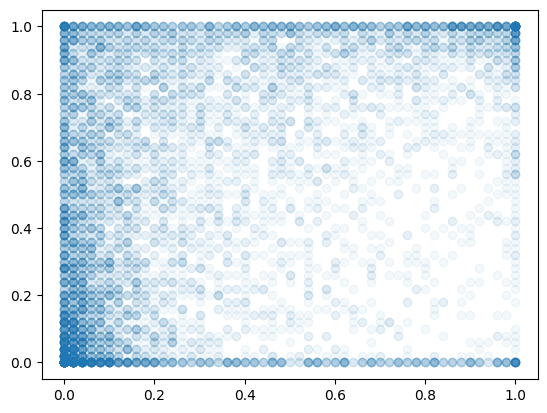

In [57]:
plt.scatter(unmemorized_acc_cummax_a[-1], unmemorized_acc_cummax_b[-1], alpha=0.05)

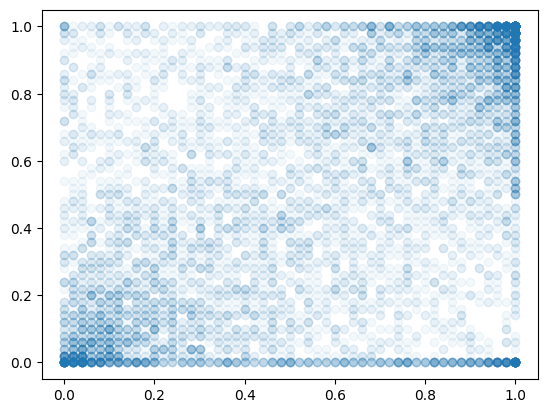

In [58]:
plt.scatter(np.max([unmemorized_acc_cummax_a[-1], unmemorized_acc_cummax_b[-1]], axis=0), unmemorized_acc_cummax_c[-1], alpha=0.05)

In [ ]:
plt.scatter(unmemorized_acc_cummax_a[-1], unmemorized_acc_cummax_b[-1], alpha=0.05)

(array([6.000e+00, 4.400e+01, 1.610e+02, 9.780e+02, 3.883e+03, 1.478e+03,
        6.650e+02, 2.190e+02, 3.600e+01, 3.000e+00]),
 array([-0.64 , -0.484, -0.328, -0.172, -0.016,  0.14 ,  0.296,  0.452,
         0.608,  0.764,  0.92 ]),
 <BarContainer object of 10 artists>)

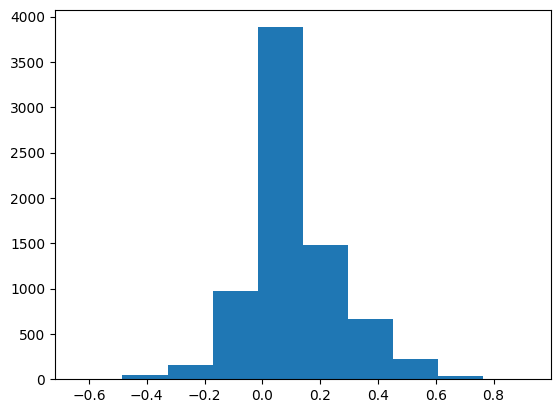

In [108]:
plt.hist(unmemorized_acc_cummax_a[-1] - unmemorized_acc_cummax_b[-1])

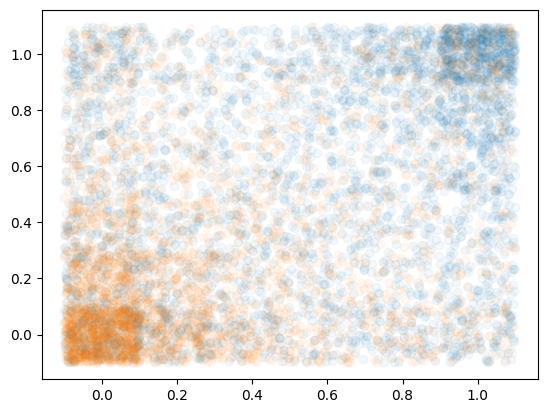

In [44]:
idxs = np.where(ratios_dict5["unmemorized_acc_cummax_all"][-1]>0.5)[0]
idxs2 = np.where(ratios_dict5["unmemorized_acc_cummax_all"][-1]<=0.5)[0]

plt.scatter(ratios_dict2["unmemorized_acc_cummax_all"][-1][idxs]+np.random.uniform(-0.1, 0.1, len(idxs)), ratios_dict1["unmemorized_acc_cummax_all"][-1][idxs]+np.random.uniform(-0.1, 0.1, len(idxs)), alpha=0.05)
plt.scatter(ratios_dict2["unmemorized_acc_cummax_all"][-1][idxs2]+np.random.uniform(-0.1, 0.1, len(idxs2)), ratios_dict1["unmemorized_acc_cummax_all"][-1][idxs2]+np.random.uniform(-0.1, 0.1, len(idxs2)), alpha=0.05)


In [23]:
ratios_dict1["unmemorized_acc_cummax_all"].mean(axis=1)

array([0.29495517, 0.35538606, 0.38760872, 0.4151211 , 0.42678978,
       0.43337348])

In [21]:
np.max([ratios_dict1["unmemorized_acc_cummax_all"], ratios_dict2["unmemorized_acc_cummax_all"]], axis=0).mean(axis=1)

array([0.42224006, 0.49107453, 0.52902449, 0.55816941, 0.57436103,
       0.58022213])

In [5]:
0.58022213 - 0.1*np.sqrt(2*np.log(2))

0.4624811277484525

In [24]:
np.max([ratios_dict1["unmemorized_acc_cummax_all"], ratios_dict2["unmemorized_acc_cummax_all"], ratios_dict3["unmemorized_acc_cummax_all"]], axis=0).mean(axis=1)

array([0.49139569, 0.56421785, 0.60281012, 0.63072394, 0.64605915,
       0.65154556])

In [2]:
import numpy as np
0.65154556 - 0.1*np.sqrt(3*np.log(2))

0.5073428713399116

In [25]:
np.max([ratios_dict1["unmemorized_acc_cummax_all"], ratios_dict2["unmemorized_acc_cummax_all"], ratios_dict3["unmemorized_acc_cummax_all"], ratios_dict4["unmemorized_acc_cummax_all"]], axis=0).mean(axis=1)

array([0.54136224, 0.64019805, 0.68657835, 0.71197645, 0.72776663,
       0.73263749])

In [3]:
0.73263749- 0.1*np.sqrt(4*np.log(2))

0.5661265677684605

In [28]:
ratios_dict1["unmemorized_acc_cummax_all"].shape

(6, 7473)

In [26]:
np.max([ratios_dict1["unmemorized_acc_cummax_all"], ratios_dict2["unmemorized_acc_cummax_all"], ratios_dict3["unmemorized_acc_cummax_all"], ratios_dict4["unmemorized_acc_cummax_all"]], axis=0)

array([[1. , 0.6, 0.2, ..., 0.2, 0.6, 0.2],
       [1. , 0.8, 0.4, ..., 0.6, 0.8, 0.4],
       [1. , 0.8, 0.4, ..., 0.8, 0.6, 0.4],
       [1. , 0.8, 0.6, ..., 1. , 0.8, 0.4],
       [1. , 0.8, 0.4, ..., 0.4, 1. , 0.4],
       [1. , 0.8, 0.4, ..., 0.6, 1. , 0.4]])

In [9]:
ratios_dict1 = get_ratios2(stats_dict1, perp_threshold=-2.4)

(6, 7473)
(6, 7473)


In [10]:
ratios_dict2 = get_ratios2(stats_dict2, perp_threshold=-2.4)

(6, 7473)
(6, 7473)


In [11]:
ratios_dict3 = get_ratios2(stats_dict3, perp_threshold=-2.4)

(6, 7473)
(6, 7473)


In [12]:
ratios_dict4 = get_ratios2(stats_dict4, perp_threshold=-2.4)

(6, 7473)
(6, 7473)


In [13]:
ratios_dict5 = get_ratios2(stats_dict5, perp_threshold=-2.4)

(6, 7473)
(6, 7473)


In [22]:
len(np.where(ratios_dict1["unmemorized_acc_cummax_all"][-1]<0.25)[0])

3465

In [23]:
len(np.where(ratios_dict2["unmemorized_acc_cummax_all"][-1]<0.25)[0])

3463

In [24]:
len(np.where(ratios_dict5["unmemorized_acc_cummax_all"][-1]<0.25)[0])

2562

In [26]:
len(np.where((ratios_dict1["unmemorized_acc_cummax_all"][-1]<0.25)*(ratios_dict2["unmemorized_acc_cummax_all"][-1]<0.25))[0])

2223

In [27]:
len(np.where((ratios_dict1["unmemorized_acc_cummax_all"][-1]<0.25)*(ratios_dict5["unmemorized_acc_cummax_all"][-1]<0.25))[0])

1752

In [28]:
len(np.where((ratios_dict2["unmemorized_acc_cummax_all"][-1]<0.25)*(ratios_dict5["unmemorized_acc_cummax_all"][-1]<0.25))[0])

1739

In [29]:
len(np.where((ratios_dict2["unmemorized_acc_cummax_all"][-1]<0.25)*(ratios_dict5["unmemorized_acc_cummax_all"][-1]<0.25)*(ratios_dict1["unmemorized_acc_cummax_all"][-1]<0.25))[0])

1345

In [38]:
ratios_dict5

{'unmemorized_acc_cummax': array([0.43259735, 0.46840626, 0.50161916, 0.52193229, 0.535742  ,
        0.54021143]),
 'unmemorized_acc_cummax_all': array([[1. , 0.2, 0.4, ..., 0.2, 0. , 0.2],
        [1. , 0.2, 0.4, ..., 0.2, 0. , 0.2],
        [1. , 0.2, 0.4, ..., 0.2, 0.6, 0.2],
        [1. , 0.2, 0.4, ..., 0.2, 0.6, 0.2],
        [1. , 0.2, 0.4, ..., 0.2, 0.6, 0.2],
        [1. , 0.2, 0.4, ..., 0.2, 0.6, 0.2]]),
 'avg_test_acc': array([0.41980288, 0.47384382, 0.50999242, 0.51308567, 0.53094769,
        0.53907506])}

In [14]:
shuffle_idxs1 = np.load("ckpts/gsm8k_orig_6epochs_shuffle1_lr5e-05_bs128/subsample_idxs.npy")

In [37]:
shuffle_idxs2 = np.load("ckpts/gsm8k_orig_6epochs_shuffle2_lr5e-05_bs128/subsample_idxs.npy")

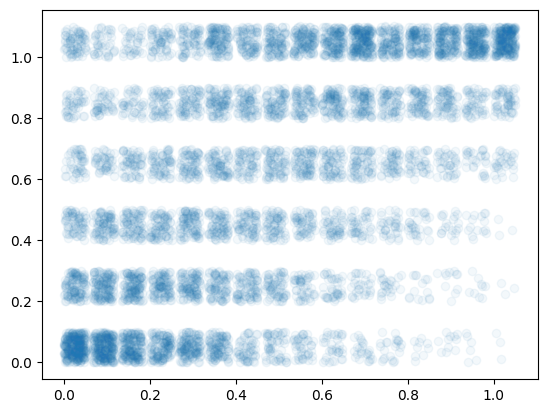

In [43]:
plt.scatter((ratios_dict1["unmemorized_acc_cummax_all"][5]+ratios_dict2["unmemorized_acc_cummax_all"][5]+ratios_dict3["unmemorized_acc_cummax_all"][5])/3+np.random.uniform(0, 0.05, len(shuffle_idxs1)), (ratios_dict4["unmemorized_acc_cummax_all"][5])+np.random.uniform(0, 0.1, len(shuffle_idxs1)), alpha=0.05)

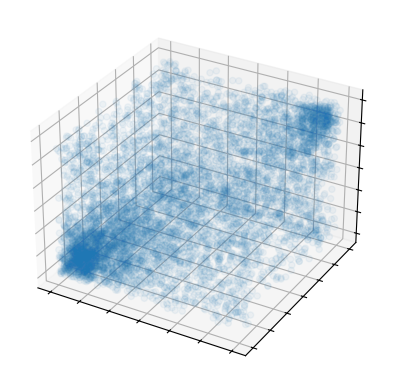

In [71]:
import matplotlib.pyplot as plt
import numpy as np

# plt.style.use('_mpl-gallery')

# Make data
np.random.seed(19680801)
n = 100
rng = np.random.default_rng()
xs = ratios_dict1["unmemorized_acc_cummax_all"][5]+np.random.uniform(0, 0.2, len(shuffle_idxs1))
ys = ratios_dict2["unmemorized_acc_cummax_all"][5]+np.random.uniform(0, 0.2, len(shuffle_idxs1))
zs = ratios_dict3["unmemorized_acc_cummax_all"][5]+np.random.uniform(0, 0.2, len(shuffle_idxs1))

# Plot
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, alpha=0.5)
ax.scatter(xs, ys, zs, alpha=0.05)

ax.set(xticklabels=[],
       yticklabels=[],
       zticklabels=[])

plt.show()

In [72]:
len(ratios_dict1["unmemorized_acc_cummax_all"][5])

7473

(array([0.     , 0.04875, 0.3525 , 0.7825 , 1.64375, 2.11125, 2.19125,
        1.5875 , 0.89875, 0.35   , 0.03375, 0.     ]),
 array([-0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,
         1. ,  1.1]),
 <BarContainer object of 12 artists>)

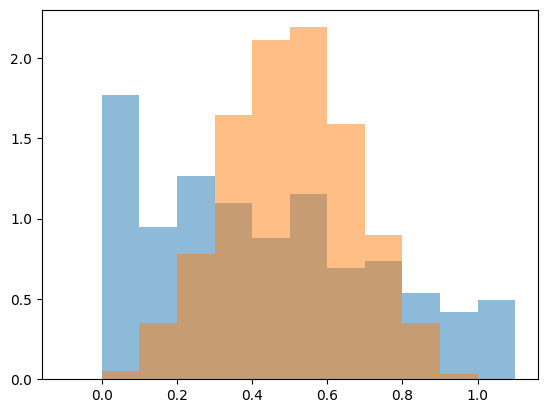

In [25]:
plt.hist((ratios_dict1["unmemorized_acc_cummax_all"][5]+ratios_dict2["unmemorized_acc_cummax_all"][5]+ratios_dict3["unmemorized_acc_cummax_all"][5])/3, bins = np.arange(-0.1, 1.1, 0.1), alpha=0.5, density=True)

plt.hist((np.random.uniform(0, 1, 8000)+np.random.uniform(0, 1, 8000)+np.random.uniform(0, 1, 8000))/3, bins = np.arange(-0.1, 1.1, 0.1), alpha=0.5, density=True)

In [48]:
(((ratios_dict1["unmemorized_acc_cummax_all"][5]+ratios_dict2["unmemorized_acc_cummax_all"][5]+ratios_dict3["unmemorized_acc_cummax_all"][5])/3)>0.85).mean()

0.13394888264418572

In [56]:
(((ratios_dict1["unmemorized_acc_cummax_all"][5]+ratios_dict2["unmemorized_acc_cummax_all"][5]+ratios_dict3["unmemorized_acc_cummax_all"][5])/3)<0.07).mean()

0.17703733440385389

In [59]:
np.save("gsm8k_unmemorized_idxs>1.npy", np.where(((ratios_dict1["unmemorized_acc_cummax_all"][5]+ratios_dict2["unmemorized_acc_cummax_all"][5]+ratios_dict3["unmemorized_acc_cummax_all"][5])/3)>=0.07)[0])

In [62]:
np.save("gsm8k_unmemorized_idxs>0.npy", np.where(((ratios_dict1["unmemorized_acc_cummax_all"][5]+ratios_dict2["unmemorized_acc_cummax_all"][5]+ratios_dict3["unmemorized_acc_cummax_all"][5])/3)>0)[0])

In [61]:
len(np.where(((ratios_dict1["unmemorized_acc_cummax_all"][5]+ratios_dict2["unmemorized_acc_cummax_all"][5]+ratios_dict3["unmemorized_acc_cummax_all"][5])/3)>0)[0])

6789

In [73]:
np.save("gsm8k_unmemorized_acc_cummax_all.npy", (ratios_dict1["unmemorized_acc_cummax_all"][5]+ratios_dict2["unmemorized_acc_cummax_all"][5]+ratios_dict3["unmemorized_acc_cummax_all"][5])/3)

(array([1323.,  707.,  947.,  819.,  658.,  863.,  519.,  549.,  403.,
         685.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

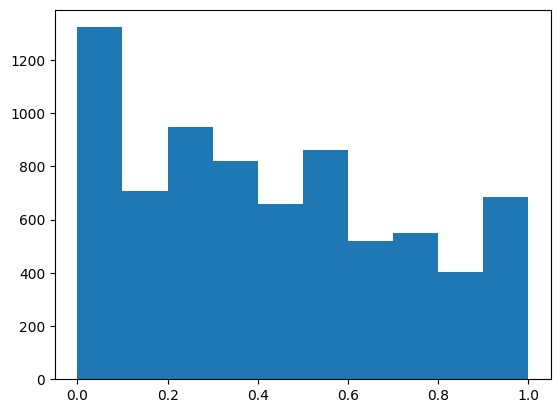

In [80]:
plt.hist((ratios_dict1["unmemorized_acc_cummax_all"][5]+ratios_dict2["unmemorized_acc_cummax_all"][5]+ratios_dict3["unmemorized_acc_cummax_all"][5])/3)

In [82]:
np.percentile((ratios_dict1["unmemorized_acc_cummax_all"][5]+ratios_dict2["unmemorized_acc_cummax_all"][5]+ratios_dict3["unmemorized_acc_cummax_all"][5])/3, 75)

0.6666666666666666

In [75]:
(np.load("ckpts/gsm8k_gpt4o_3epochs_add_memorized_lr5e-05_bs128/checkpoint-261/test_answer_types5_seed2_temp0.8.npy")==0).mean()

0.531918119787718

In [76]:
(np.load("ckpts/gsm8k_gpt4o_3epochs_add_unmemorized_lr5e-05_bs128/checkpoint-261/test_answer_types5_seed2_temp0.8.npy")==0).mean()

0.5153904473085671

In [79]:
(np.load("ckpts/gsm8k_orig_3epochs_full_lr5e-05_bs128/checkpoint-174/test_answer_types50_seed2_temp0.8.npy")==0).mean()

0.45332827899924183

In [64]:
len(np.load("gsm8k_unmemorized_idxs>1.npy"))

6150

In [66]:
7473-6150

1323

In [ ]:
(ratios_dict1["unmemorized_acc_cummax_all"][5]+ratios_dict2["unmemorized_acc_cummax_all"][5]+ratios_dict3["unmemorized_acc_cummax_all"][5])/3

In [ ]:
bins = [-0.1, 0.1, 0.3, 0.5, 0.7, 0.9, 1.1]

(array([2396., 1180.,  854.,  759.,  821., 1463.]),
 array([-0.1,  0.1,  0.3,  0.5,  0.7,  0.9,  1.1]),
 <BarContainer object of 6 artists>)

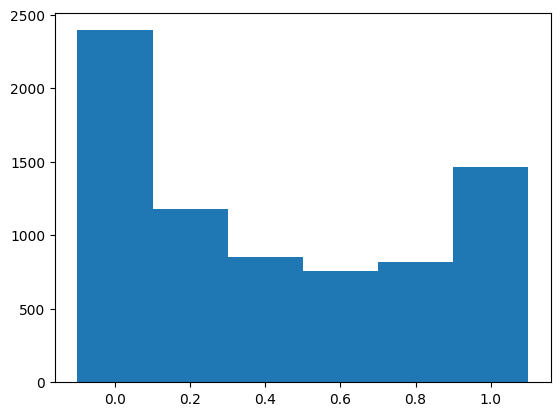

In [17]:
plt.hist((ratios_dict3["unmemorized_acc_cummax_all"][5]), bins = [-0.1, 0.1, 0.3, 0.5, 0.7, 0.9, 1.1])

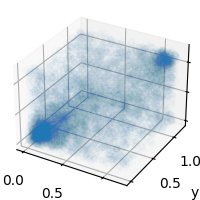

In [ ]:
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xs = ratios_dict1["unmemorized_acc_cummax_all"][5]+np.random.uniform(0, 0.2, len(shuffle_idxs1))
ys = ratios_dict2["unmemorized_acc_cummax_all"][5]+np.random.uniform(0, 0.2, len(shuffle_idxs1))
zs = ratios_dict3["unmemorized_acc_cummax_all"][5]+np.random.uniform(0, 0.2, len(shuffle_idxs1))

ax.scatter(xs, ys, zs, alpha=0.01)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

# plt.show()

(array([0.96079219, 0.69249297, 0.60685133, 0.62625452, 0.76475311,
        1.34885588]),
 array([-0.1,  0.1,  0.3,  0.5,  0.7,  0.9,  1.1]),
 <BarContainer object of 6 artists>)

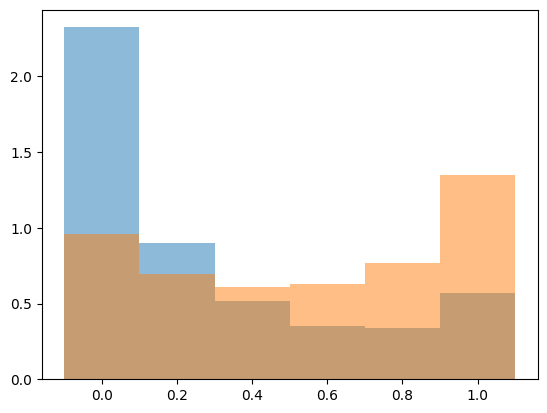

In [146]:
# subsample_idxs = np.where((ratios_dict1["unmemorized_acc_cummax_all"][5]==1)*(ratios_dict2["unmemorized_acc_cummax_all"][5]==1)*(ratios_dict3["unmemorized_acc_cummax_all"][5]==1))[0]
subsample_idxs = np.where((ratios_dict1["unmemorized_acc_cummax_all"][5]==0)*(ratios_dict2["unmemorized_acc_cummax_all"][5]==0)*(ratios_dict3["unmemorized_acc_cummax_all"][5]==0))[0]


plt.hist(ratios_dict4["unmemorized_acc_cummax_all"][5][subsample_idxs], bins = [-0.1, 0.1, 0.3, 0.5, 0.7, 0.9, 1.1], alpha=0.5, density=True)
plt.hist(ratios_dict4["unmemorized_acc_cummax_all"][5], bins = [-0.1, 0.1, 0.3, 0.5, 0.7, 0.9, 1.1], alpha=0.5, density=True)

In [135]:
np.where(ratios_dict2["unmemorized_acc_cummax_all"][5]>0.5)[0]

array([   0,    6,   12, ..., 7465, 7466, 7468])

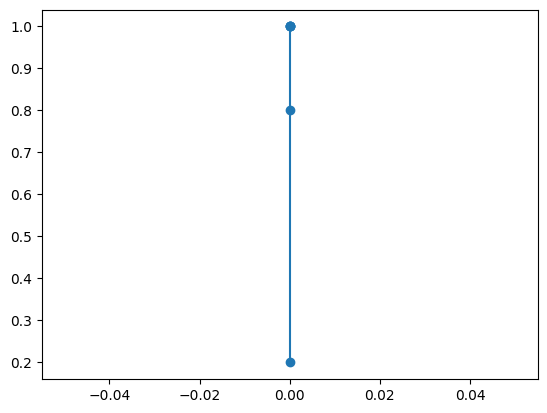

In [92]:
idx = 30

plt.plot(ratios_dict1["unmemorized_acc_cummax_all"][:, idx], ratios_dict2["unmemorized_acc_cummax_all"][:, idx], "o-")

In [95]:
ratios_dict2["unmemorized_acc_cummax_all"][:, idx]

array([0.2, 0.8, 1. , 1. , 1. , 1. ])

In [93]:
ckpts = ["58", "116", "175", "233", "292", "348"]


for ckpt in ckpts:
    train_samples = (np.load("ckpts/"+"gsm8k_orig_6epochs_shuffle1_lr5e-05_bs128"+"/checkpoint-"+ckpt+ "/train_answers5_seed2_temp0.8.npy"))
    print(train_samples[30])

[' First find how many pizza pieces Bill eats: 4 pieces * 50% = <<4*50*.01=2>>2 pieces\nThen find how many pizza pieces Dale eats: 4 pieces * 50% = <<4*50*.01=2>>2 pieces\nThen find how many pizza pieces Ann eats: 4 pieces * 75% = <<4*75*.01=3>>3 pieces\nThen find how many pizza pieces Cate eats: 4 pieces * 75% = <<4*75*.01=3>>3 pieces\nThen add the number of pieces each person eats to find the total number of pieces uneaten: 2 pieces + 2 pieces + 3 pieces + 3 pieces = <<2+2+3+3=14>>14 pieces\n#### 14'
 ' First find the number of pieces each person eats: 50% of pieces * 4 pieces/person = <<50*.01*4=2>>2 pieces/person\nThen multiply the number of pieces by the number of people to find the total number of pieces eaten: 2 pieces/person * 4 people = <<2*4=8>>8 pieces\nThen subtract the number of pieces eaten from the total number of pieces to find the number uneaten: 12 pieces - 8 pieces = <<12-8=4>>4 pieces\n#### 4'
 ' First find the total number of pizza pieces Bill and Dale eat: 50% * 4

In [94]:
ckpts = ["58", "116", "175", "233", "292", "348"]


for ckpt in ckpts:
    train_samples = (np.load("ckpts/"+"gsm8k_orig_6epochs_shuffle2_lr5e-05_bs128"+"/checkpoint-"+ckpt+ "/train_answers5_seed2_temp0.8.npy"))
    print(train_samples[30])

[' Bill and Dale eat a total of 50/100 * 4 = <<50/100*4=2>>2 pieces.\nAnn and Cate eat a total of 75/100 * 4 = <<75/100*4=3>>3 pieces.\nTherefore, there are 4 - 2 - 3 = <<4-2-3=1>>1 pieces left uneaten.\n#### 1'
 ' Bill and Dale eat 50/100*4 = <<50/100*4=2>>2 pizza pieces.\nAnn and Cate eat 75/100*4 = <<75/100*4=3>>3 pizza pieces.\nThere are a total of 4+2+3 = <<4+2+3=9>>9 pizza pieces eaten.\nTherefore, there are 9-4 = <<9-4=5>>5 pizza pieces left uneaten.\n#### 5'
 ' Bill and Dale eat 4 x 2 = <<4*2=8>>8 pieces.\nAnn and Cate eat 4 x 2 = <<4*2=8>>8 pieces.\nThe total number of pieces eaten is 8 + 8 = <<8+8=16>>16 pieces.\nThe original number of pieces was 16 x 4 = <<16*4=64>>64 pieces.\nThere are 64 - 16 = <<64-16=48>>48 pieces left uneaten.\n#### 48'
 ' Bill eats 1 x 4 = <<1*4=4>>4 pizza pieces.\nDale eats 1 x 4 = <<1*4=4>>4 pizza pieces.\nAnn and Cate eat 4 x 2 = <<4*2=8>>8 pizza pieces.\nAnn and Cate are left with 4 - 8 = <<4-8=2>>2 pizza pieces.\n#### 2'
 ' Bill and Dale eat 4 x 5

In [ ]:
stats_dict1

(array([1.60310451, 0.7895089 , 0.57139034, 0.50782818, 0.54931085,
        0.97885722]),
 array([-0.1,  0.1,  0.3,  0.5,  0.7,  0.9,  1.1]),
 <BarContainer object of 6 artists>)

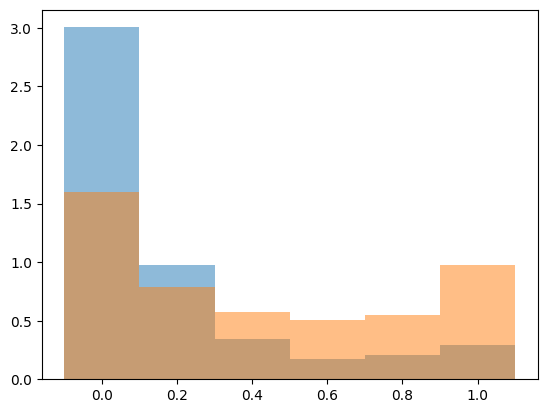

In [115]:
plt.hist(ratios_dict3["unmemorized_acc_cummax_all"][5][np.where((ratios_dict1["unmemorized_acc_cummax_all"][5]==0)*(ratios_dict2["unmemorized_acc_cummax_all"][5]==0))[0]], bins = [-0.1, 0.1, 0.3, 0.5, 0.7, 0.9, 1.1], alpha=0.5, label="Both shuffle1 and shuffle2 memorized", density = True)
plt.hist(ratios_dict3["unmemorized_acc_cummax_all"][5], bins = [-0.1, 0.1, 0.3, 0.5, 0.7, 0.9, 1.1], alpha=0.5, label="Both shuffle1 and shuffle2 memorized", density = True)

In [131]:
unmatched_idxs = np.where((ratios_dict1["unmemorized_acc_cummax_all"][5]<=0.2)*(ratios_dict2["unmemorized_acc_cummax_all"][5]<=0.2))[0]

train_order_subsample = []
for i in range(len(unmatched_idxs)):
    train_order_subsample.append(np.where(shuffle_idxs1 == unmatched_idxs[i])[0][0])



(array([1.19489429e-04, 1.65176563e-04, 1.33547009e-04, 1.40575798e-04,
        1.47604588e-04, 1.37061404e-04, 1.05431849e-04, 1.33547009e-04,
        1.40575798e-04, 1.65176563e-04, 1.26518219e-04, 1.37061404e-04,
        1.44090193e-04, 1.51118983e-04, 1.19489429e-04, 1.33547009e-04,
        1.15975034e-04, 1.47604588e-04, 1.33547009e-04, 9.48886640e-05,
        1.05431849e-04, 1.33547009e-04, 1.26518219e-04, 1.37061404e-04,
        1.26518219e-04, 1.47604588e-04, 1.44090193e-04, 1.44090193e-04,
        1.08946244e-04, 1.30032614e-04, 1.33547009e-04, 1.23003824e-04,
        1.37061404e-04, 9.84030589e-05, 1.26518219e-04, 1.40575798e-04,
        1.72205353e-04, 1.44090193e-04, 1.51118983e-04, 9.84030589e-05,
        1.40575798e-04, 1.37061404e-04, 1.40575798e-04, 1.37061404e-04,
        1.08946244e-04, 1.37061404e-04, 1.30032614e-04, 1.72205353e-04,
        1.15975034e-04, 1.47604588e-04, 1.23003824e-04, 1.33547009e-04,
        1.33547009e-04, 1.23003824e-04, 1.54633378e-04, 1.476045

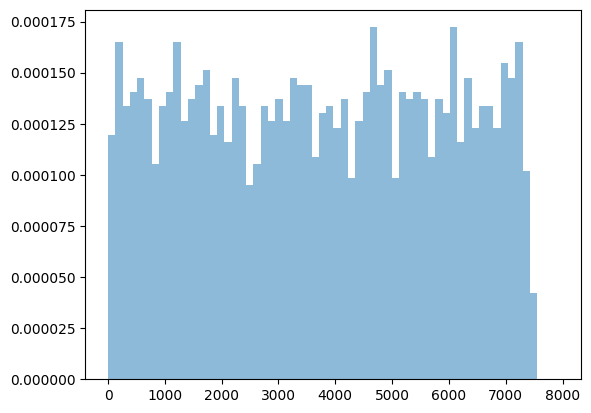

In [132]:
plt.hist(train_order_subsample, bins = np.arange(0, 8000, 128), alpha=0.5, label="Both shuffle1 and shuffle2 memorized", density = True)


In [56]:
len(np.where((ratios_dict1["unmemorized_acc_cummax_all"][5]<=0.2)*(ratios_dict2["unmemorized_acc_cummax_all"][5]<=0.2))[0])

1425

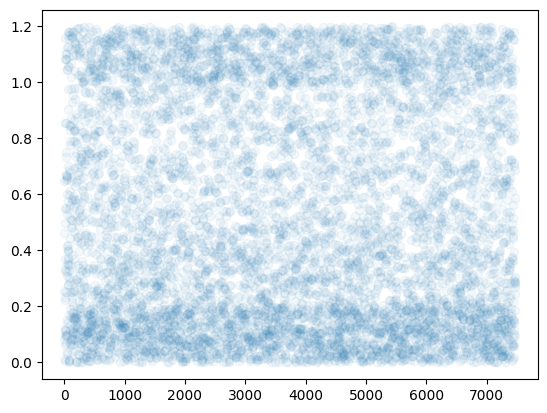

In [112]:
plt.scatter(np.arange(len(shuffle_idxs1)), ratios_dict1["unmemorized_acc_cummax_all"][5, shuffle_idxs1]+np.random.uniform(0, 0.2, len(shuffle_idxs1)), alpha=0.05)

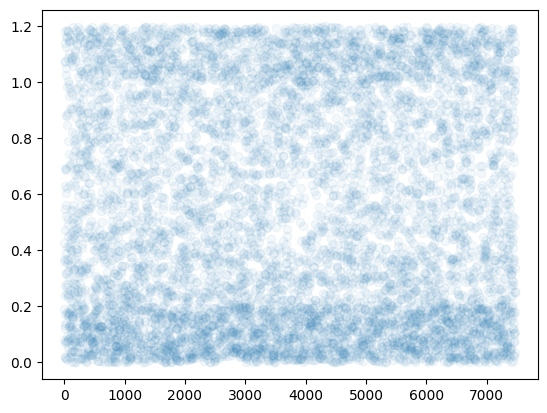

In [113]:
plt.scatter(np.arange(len(shuffle_idxs1)), ratios_dict2["unmemorized_acc_cummax_all"][5, shuffle_idxs2]+np.random.uniform(0, 0.2, len(shuffle_idxs1)), alpha=0.05)